In [20]:
import torch
import torchvision
import torchvision.transforms as T
from torch import nn 
from torch import optim
import torch.nn.functional as F
import torchvision.datasets as dset
from torch.utils.data import sampler
from torch.utils.data import DataLoader
from torch.autograd import Variable

import matplotlib.pyplot as plt ### воспользуемся для отображения изображения
import numpy as np
import pandas as pd

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


C:\ProgramData\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# define transforms for normalization and data augmentation
transform_augment = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4)])
transform_normalize = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
NUM_TRAIN = 45000
NUM_VAL = 5000
batch_size = 64

In [5]:
train_dataset = torchvision.datasets.CIFAR10(root='./dataset_train',
                                             train=True,  
                                             transform=T.Compose([transform_augment, transform_normalize]), 
                                             download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

Extracting ./dataset_train\cifar-10-python.tar.gz to ./dataset_train


In [6]:
test_dataset = torchvision.datasets.CIFAR10(root='./dataset_test', train=False,
                                       download=True, transform=transform_normalize)

Extracting ./dataset_test\cifar-10-python.tar.gz to ./dataset_test


In [16]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                         shuffle=False)

In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
net = Net().to(device)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [12]:
num_down_loss = 0
loss_bufer = 0
stat_loss = list()

for epoch in range(1000):  
    running_loss_ = 0.0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
#         running_loss += loss.item()
        running_loss_ += loss.item()
        
#         if i % 1000 == 0:    # печатаем каждые 300 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 1000))
#             running_loss = 0.0
    
    running_loss_ = running_loss_ / len(train_loader)
    print(f'epoch: {epoch}. loss: {running_loss_}')
    if loss_bufer < running_loss_:
        num_down_loss += 1
    else:
        num_down_loss = 0
        
    loss_bufer = running_loss_
    stat_loss.append(running_loss_)
    running_loss_ = 0
    
    if num_down_loss > 20:
        print('Early stopping')
        break  
        

print('Training is finished!')

epoch: 0. loss: 2.1520347970221048
epoch: 1. loss: 1.943014399474844
epoch: 2. loss: 1.822165665571647
epoch: 3. loss: 1.7326574403306712
epoch: 4. loss: 1.6623535288874145
epoch: 5. loss: 1.6112569556821643


KeyboardInterrupt: 

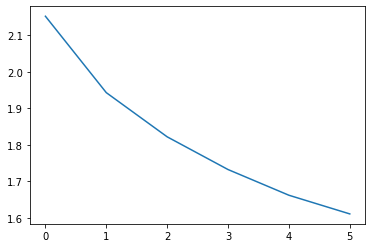

In [13]:
plt.plot(stat_loss)
plt.show()

In [17]:
data_iter = iter(test_loader)
images, labels = data_iter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship   car  ship


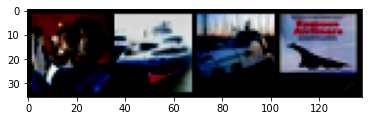

In [18]:
outputs = net(images)
imgs = torchvision.utils.make_grid(images)
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

_, predicted = torch.max(outputs, 1)
print('Predicted:   ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Взять часть, где мы делали один шаг обучения, и обернуть его в цикл по схеме, как обучали модель в конце занятия.

In [34]:
linear = nn.Linear(2, 2)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(linear.parameters(), lr=0.01)

x = Variable(torch.randn(2), requires_grad = True)
y = Variable(torch.randn(2), requires_grad = False)

dataset = torch.utils.data.TensorDataset(x, y)
loader = torch.utils.data.DataLoader(dataset, batch_size=2, pin_memory=True)

optimizer.zero_grad()
pred = linear(x)
loss = criterion(pred, y)
print('loss: ', loss.item())

loss:  4.0759596824646


In [56]:
for epoch in range(10):  
    running_loss = 0.0
    for i, data in enumerate(loader):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = linear(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'loss: {running_loss/len(loader)}')
    running_loss=0

print('Training is finished!')

loss: 0.004357906058430672
loss: 0.004259653855115175
loss: 0.004163614474236965
loss: 0.004069743677973747
loss: 0.003978003282099962
loss: 0.00388831808231771
loss: 0.003800650592893362
loss: 0.0037149800918996334
loss: 0.003631218336522579
loss: 0.00354934623464942
Training is finished!


Переписать на PyTorch:

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.f1 = nn.Flatten((28, 28),128)
        self.l1 = nn.Linear(128, 128)
        self.d1 = nn.Dropout(0.2)
        self.l2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.f1(x)
        x = F.relu(self.l1(x))
        x = self.d1(x)
        x = F.softmax(self.l2(x))
        return x